In [105]:
#system
import os
#variable
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
#plot
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import ptitprince as pt
# model
import kabuki
import hddm
from hddm import HDDMRegressor
# stats
import bambi as bmb
from scipy.stats import pearsonr

In [106]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

The code is originated from wieck(2013).

Because the raw code is based on python 2.0, and plenty of them is to campare different model and fitting method, this notebook is just to valid the parameter recovery of hddm.

So we only use the code we need.

## params

In [107]:
n_subjs=12
n_trials=50
effect=0.5

in `params = hddm.generate.gen_rand_params()`

`    
params["sv"] = 2.5 * rand() if "sv" in include else 0

params["sz"] = rand() * 0.4 if "sz" in include else 0

params["st"] = rand() * 0.35 if "st" in include else 0

params["z"] = 0.4 + rand() * 0.2 if "z" in include else 0.5

params["v"] = (rand() - 0.5) * 8

params["t"] = 0.2 + rand() * 0.3

params["a"] = 0.5 + rand() * 1.5`

In [108]:
# generate params at population level
params = hddm.generate.gen_rand_params()
params['v_slope'] = effect
params['v_inter'] = 1
params['sv'] = 0
del params['v']
reg_outcomes=['v']
share_noise = ('a','v','t','st','sz','sv','z', 'v_slope', 'v_inter')
group_params=[]

# set valid param ranges
bounds = {'a': (0, np.inf),
          'z': (0, 1),
          't': (0, np.inf), #change
          'st': (0, np.inf),
          'sv': (0, np.inf),
          'sz': (0, 1)
}
for i_subj in range(n_subjs):
    # generate params at subject level
    subj_params = kabuki.generate._add_noise({'none': params}, 
                               noise=OrderedDict([('v', 0.2),
                               ('a', 0.2),
                               ('t', 0.1),
                               ('sv', 0.1),
                               ('v_inter', 0.1)]), 
                               share_noise=share_noise,
                                        check_valid_func=hddm.utils.check_params_valid,
                                        bounds=bounds,
                                        exclude_params={'reg_outcomes', 'st', 'sv', 'sz', 'z'})['none']
    
    #generate v
    wfpt_params = deepcopy(subj_params)
    wfpt_params.pop('v_inter')
    effect = wfpt_params.pop('v_slope')
    x1 = np.random.randint(2,size=n_trials)
    wfpt_params['v'] = (effect*x1) + subj_params['v_inter']
    
    #generate rt and choice of each trial
    i_params = deepcopy(wfpt_params)
    sampled_rts = pd.DataFrame(np.zeros((n_trials, 2)), columns=['rt', 'response'])
    for i_sample in range(len(sampled_rts)):
        #get current params
        for p in reg_outcomes:
            i_params[p] = wfpt_params[p][i_sample]
        #sample
        sampled_rts.iloc[i_sample,:] = hddm.generate.gen_rts(size=1, method='drift', dt=1e-3, **i_params).values
    sampled_rts['subj_idx']=i_subj
    sampled_rts['cov']=x1
    subj_data=sampled_rts
    
    # create dataframe
    subj_params = pd.DataFrame([subj_params])
    # add subject
    subj_params['subj_idx'] = i_subj
    subj_params['v']=wfpt_params['v'].mean()
    
    # param v
    subj_v = pd.DataFrame({'v':wfpt_params['v'],
             'cov':x1,
            'subj_idx':i_subj})
    
    
    #concatante subj_data to group_data
    if i_subj == 0:
        group_params = subj_params
    else:
        group_params = pd.concat((group_params, subj_params), ignore_index=True)

    #concatante subj_data to group_data
    if i_subj == 0:
        data = subj_data
    else:
        data = pd.concat((data, subj_data), ignore_index=True)
    
    #concatante subj_data to group_data
    if i_subj == 0:
        wfpt_v = subj_v
    else:
        wfpt_v = pd.concat((wfpt_v, subj_v), ignore_index=True)

In [109]:
group_params

,sv,sz,st,z,t,a,v_slope,v_inter,subj_idx,v
0,0,0,0,0.5,0.459679,0.921568,0.5,1.032211,0,1.262211
1,0,0,0,0.5,0.280690,0.904206,0.5,0.925630,1,1.125630
2,0,0,0,0.5,0.234695,0.434983,0.5,1.048505,2,1.268505
3,0,0,0,0.5,0.207311,1.260569,0.5,0.990706,3,1.170706
4,0,0,0,0.5,0.307357,0.822056,0.5,0.931954,4,1.121954
5,0,0,0,0.5,0.219265,0.969220,0.5,0.938950,5,1.168950
6,0,0,0,0.5,0.290234,0.954549,0.5,1.060660,6,1.270660
7,0,0,0,0.5,0.490276,0.690881,0.5,0.880439,7,1.180439
8,0,0,0,0.5,0.199373,0.858197,0.5,0.878085,8,1.098085
9,0,0,0,0.5,0.443441,1.403081,0.5,1.310047,9,1.550047


In [110]:
# contrust model
m1 = bmb.Model("v ~ 1+cov+(1|subj_idx)", data=wfpt_v)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=1,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [v_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, cov, Intercept]


/opt/conda/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)

The default initialization using init='auto' has failed, trying to recover by switching to init='adapt_diag'
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [v_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, cov, Intercept]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `1|subj_idx_offset`.ravel()[0] is zero.
The derivative of RV `1|subj_idx_offset`.ravel()[4] is zero.
The derivative of RV `1|subj_idx_offset`.ravel()[8] is zero.
The derivative of RV `cov`.ravel()[0] is zero.
The derivative of RV `Intercept`.ravel()[0] is zero.

In [ ]:
az.plot_posterior(res1, 
                  var_names=['Intercept','cov'], 
                  ref_val=[group_params['v_inter'].mean(),0.5]
                 )

In [ ]:
sns.regplot(x1,wfpt_params['v'])

In [ ]:
pearsonr(x1,wfpt_params['v'])

In [ ]:
param = group_params

In [ ]:
# select the specific coloumn
param = param[['v','a','t','z','subj_idx']]
# store the wide data to linear regression
param_pm = param
# wide to long
param = param.melt(id_vars='subj_idx', 
                   var_name='param', 
                   value_name='value' )
param

In [ ]:
# create figure
f, ax = plt.subplots(2,2,figsize=(10, 10))
# the right figure
# v
ax[0,0]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
ax[0,0].set_xlabel('v')
# z
ax[0,1]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
ax[0,1].set_xlabel('z')
# a
ax[1,0]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
ax[1,0].set_xlabel('a')
# t
ax[1,1]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
ax[1,1].set_xlabel('t')


In [114]:
print('the mean of parameter v is {:.3f} and the std is {:.3f} '.format(param_pm.v.mean(), param_pm.v.std()))
print('the mean of parameter z is {:.3f} and the std is {:.3f} '.format(param_pm.z.mean(), param_pm.z.std()))
print('the mean of parameter a is {:.3f} and the std is {:.3f} '.format(param_pm.a.mean(), param_pm.a.std()))
print('the mean of parameter t is {:.3f} and the std is {:.3f} '.format(param_pm.t.mean(), param_pm.t.std()))

the mean of parameter v is 1.251 and the std is 0.107 
the mean of parameter z is 0.500 and the std is 0.000 
the mean of parameter a is 0.569 and the std is 0.271 
the mean of parameter t is 0.372 and the std is 0.084 


In [ ]:
# the rt distribution
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2)

In [111]:
data

,rt,response,subj_idx,cov
0,0.835250,1.0,0,0
1,0.527250,1.0,0,1
2,0.579250,1.0,0,0
3,0.603250,1.0,0,1
4,0.825250,1.0,0,1
...,...,...,...,...
595,0.412384,0.0,11,0
596,0.248384,1.0,11,0
597,0.294384,1.0,11,0
598,0.300384,1.0,11,1


## model

In [112]:
m = hddm.HDDMRegressor(data, 
                       'v~cov', 
                       group_only_regressors=False,
                       keep_regressor_trace=True,
                      )
m.sample(4000,burn=1000)

Adding these covariates:
['v_Intercept', 'v_cov']
 [-----------------100%-----------------] 4000 of 4000 complete in 713.1 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_cov
Plotting v_cov_std


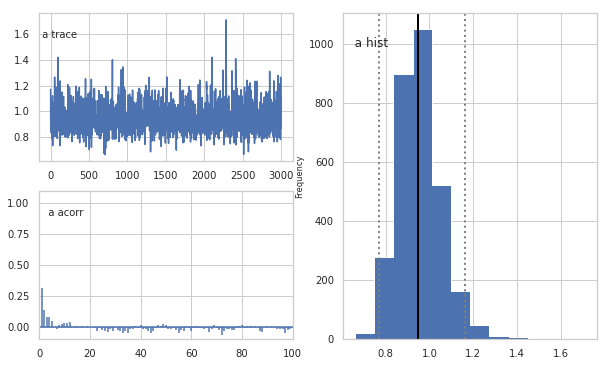

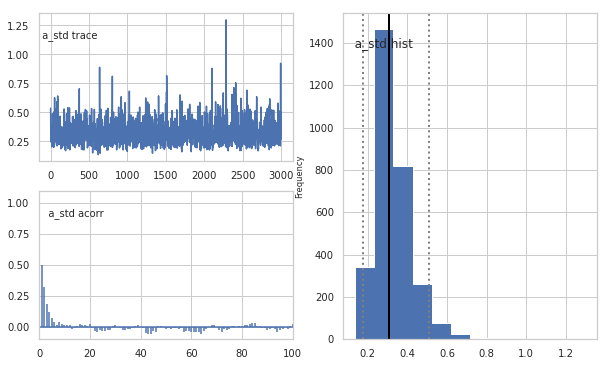

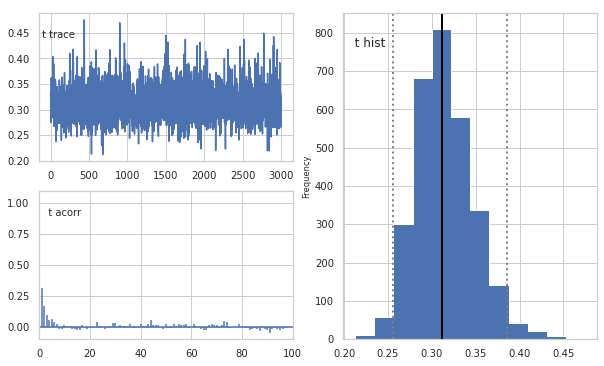

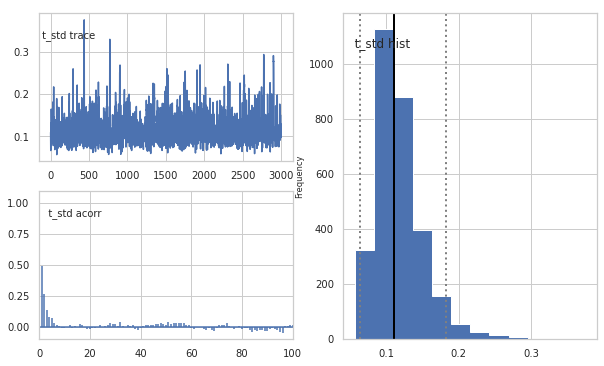

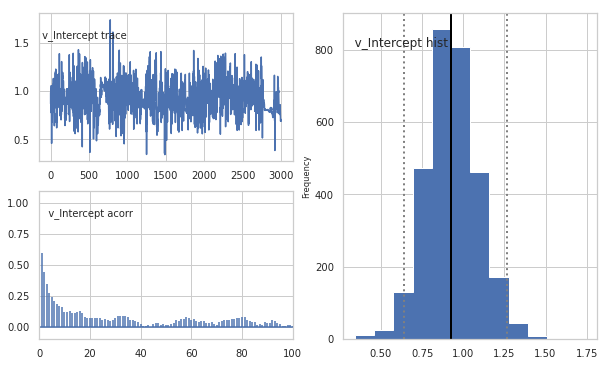

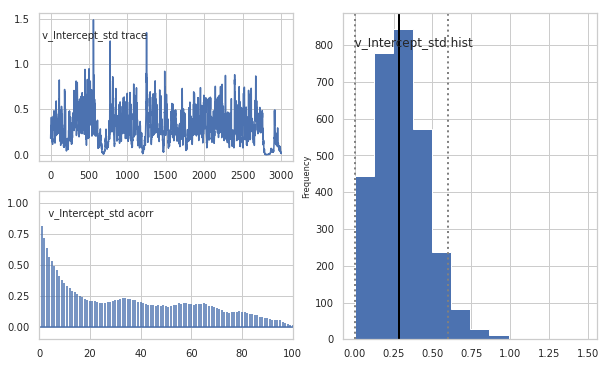

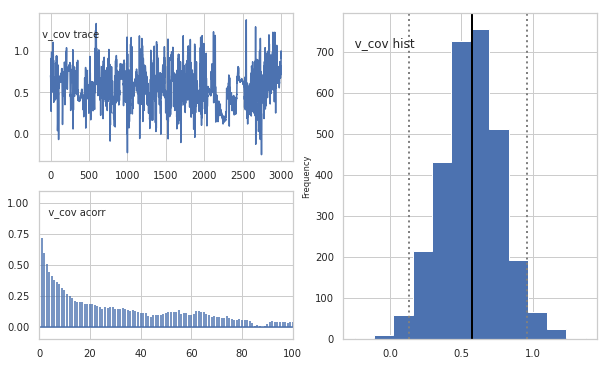

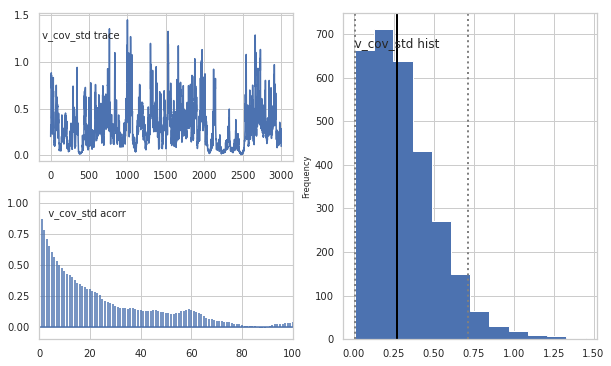

In [113]:
m.plot_posteriors()

In [115]:
m.get_traces().to_csv('mres.csv')

In [116]:
m1res_trace = pd.read_csv('mres.csv')

## result

### population params

In [117]:
param_pm

,v,a,t,z,subj_idx
0,1.316953,0.820600,0.284632,0.5,0
1,1.293439,0.477279,0.248924,0.5,1
2,1.403310,0.470046,0.465857,0.5,2
3,1.139943,0.707131,0.411524,0.5,3
4,1.257564,0.583706,0.366958,0.5,4
5,1.089475,0.588205,0.336284,0.5,5
6,1.391347,0.999196,0.487445,0.5,6
7,1.376607,0.143235,0.339117,0.5,7
8,1.246927,0.557674,0.396599,0.5,8
9,1.152813,0.925798,0.285225,0.5,9


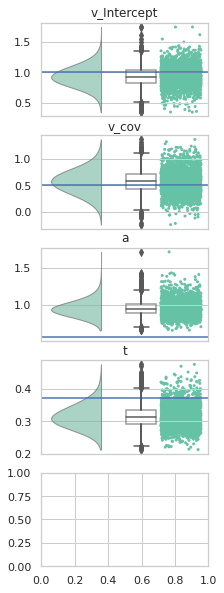

In [118]:
pms = ['v_Intercept','v_cov','a','t']
# create figure
f,ax = plt.subplots(5,figsize=(3,10))
for i,pm in enumerate(pms):
    if pm == 'a' or pm == 't':
        varname = os.path.join(str(pm))
        data = m1res_trace[varname]
        # ground parameter of group effect
        gpm = param_pm[pm].mean()
    elif pm == 'v_Intercept':
        varname = os.path.join(str(pm ))
        data = m1res_trace[varname]
        gpm= 1
    elif pm == 'v_cov':
        varname = os.path.join(str(pm ))
        data = m1res_trace[varname]
        gpm=0.5        
    elif pm == 'z':
        varname = os.path.join(str(pm +'_trans'))
        data = 1/(1+np.exp(-m1res_trace[varname]))
        gpm=param_pm[pm].mean()
    
    # raincloud
    ax_i = pt.RainCloud(data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax[i])
    ax_i.axhline(gpm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(pm)

### subject params

#### v

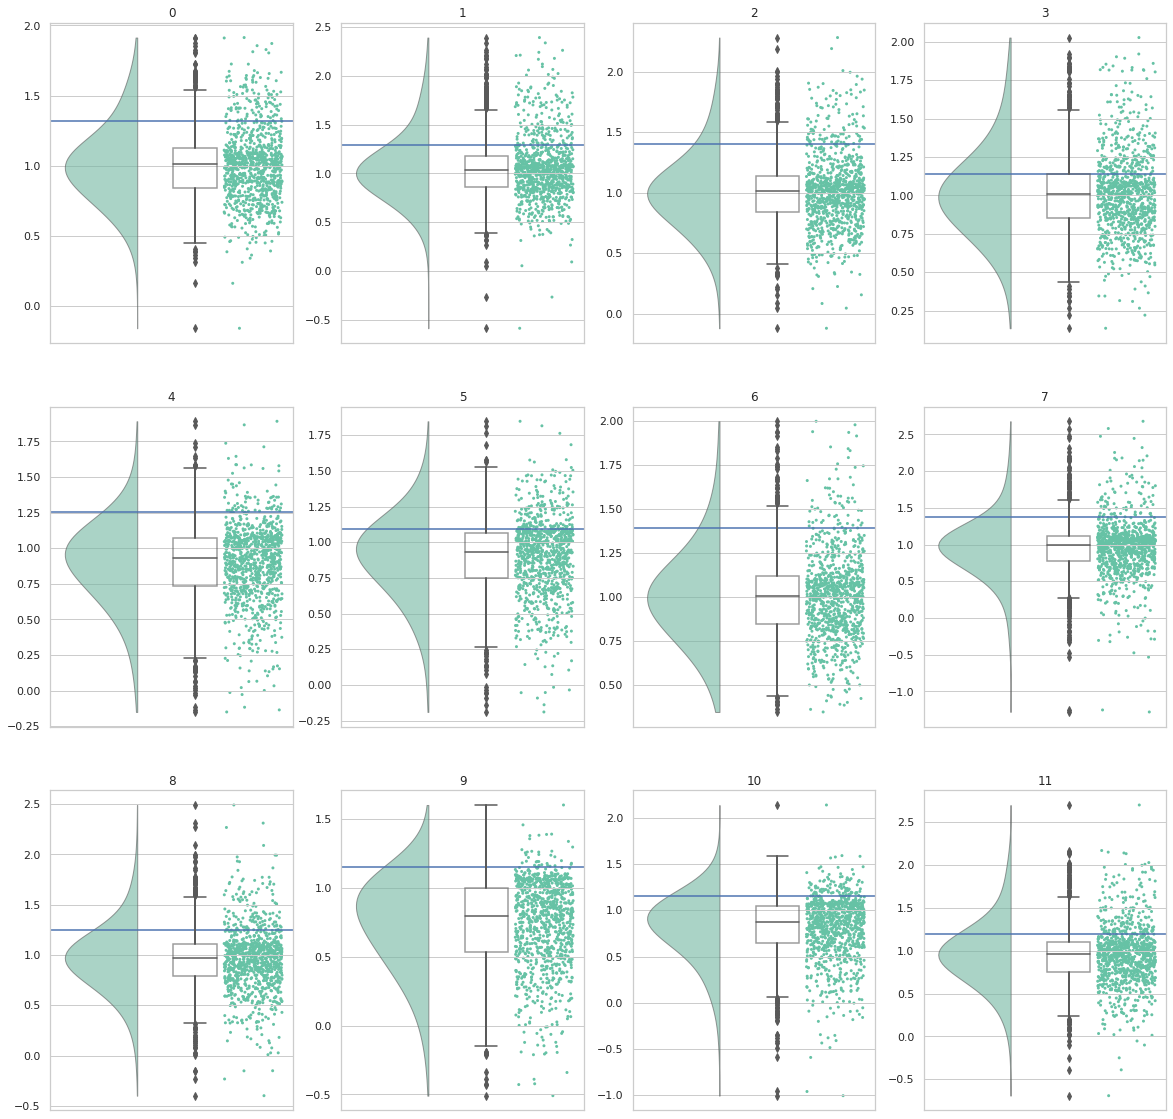

In [84]:
param = 'v'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'v'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### z

KeyError: 'z_subj_trans.0'

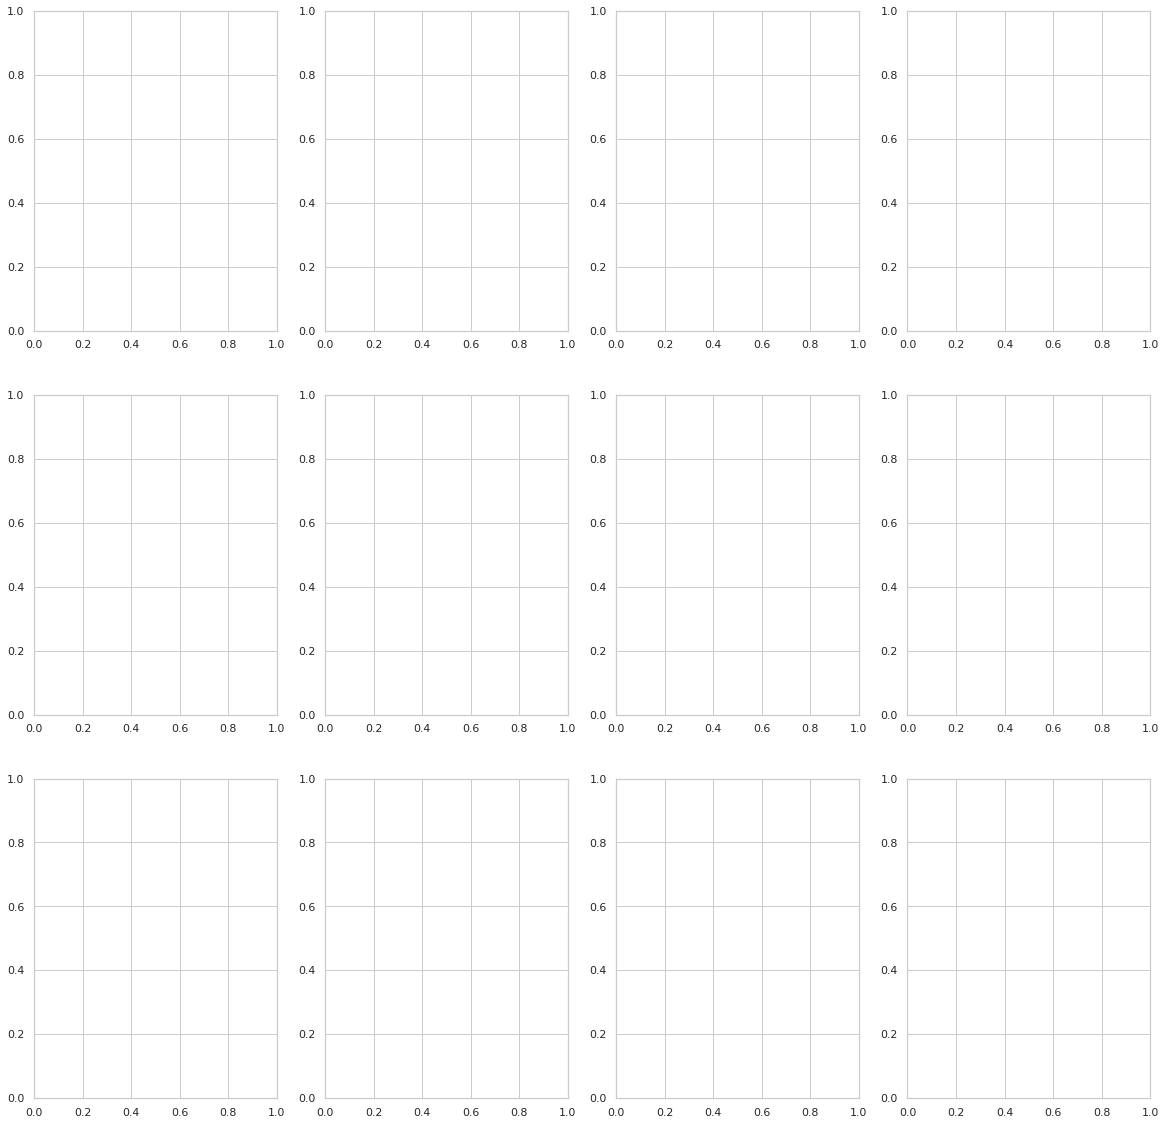

In [85]:
param = 'z'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_subj_trans.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'z'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = 1/(1+np.exp(-m1res_trace[varname])), 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### t

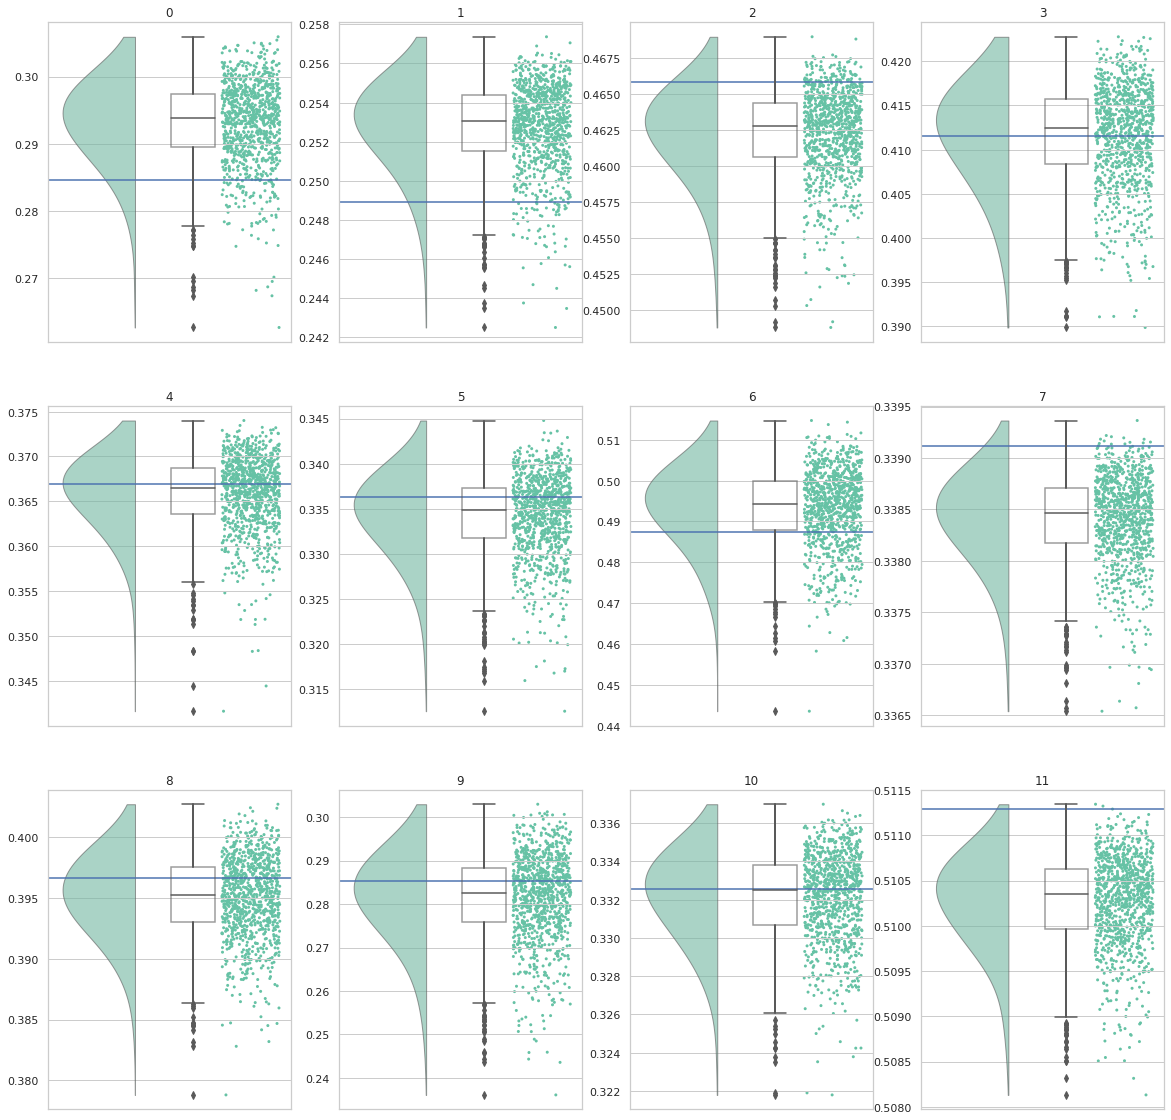

In [86]:
param = 't'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'t'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### a

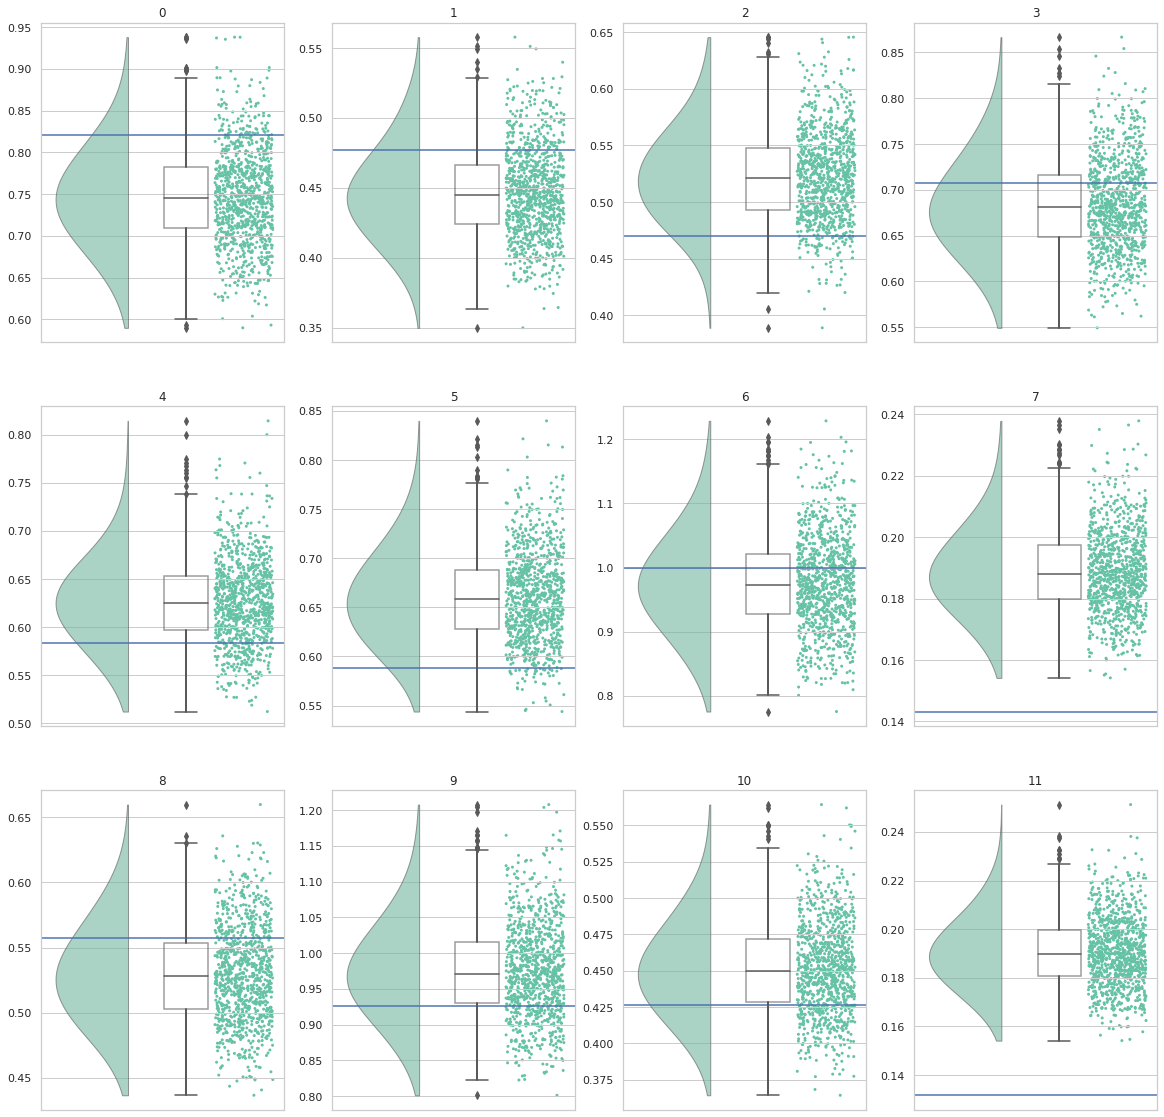

In [87]:
param = 'a'
# create figure
f,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(n_subjs):
    varname = os.path.join(str(param +'_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'a'].values[0]
    # raincloud
    ax_i = ax[i//4,i%4]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)